In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
np.random.seed(42)

n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})
df.head()


,date,sales
0,2025-08-01,31.986857
1,2025-08-02,37.539230
2,2025-08-03,42.887978
3,2025-08-04,41.252875
4,2025-08-05,25.820440


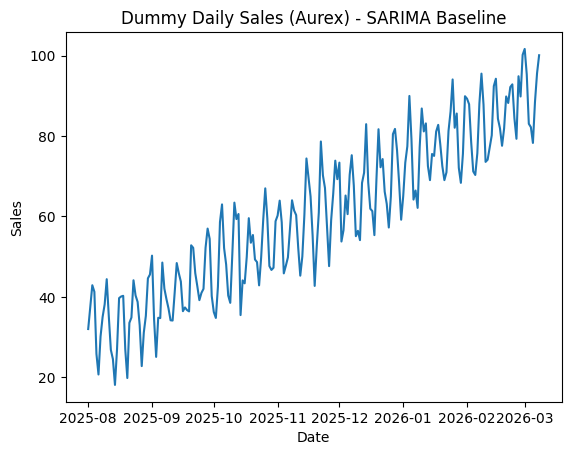

In [3]:
plt.figure()
plt.plot(df["date"], df["sales"])
plt.title("Dummy Daily Sales (Aurex) - SARIMA Baseline")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [4]:
y = df["sales"].astype(float)
split = int(len(y) * 0.8)

train = y.iloc[:split]
test  = y.iloc[split:]


In [5]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

model = SARIMAX(
    train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit = model.fit(disp=False)
print(fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  176
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -444.209
Date:                           Thu, 05 Feb 2026   AIC                            898.419
Time:                                   18:19:28   BIC                            913.764
Sample:                                        0   HQIC                           904.650
                                           - 176                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0507      0.098     -0.520      0.603      -0.242       0.141
ma.L1         -1.0000    214.582     -0.005

In [6]:
forecast = fit.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

mae, rmse


(3.033569062072822, np.float64(4.1362597899281806))

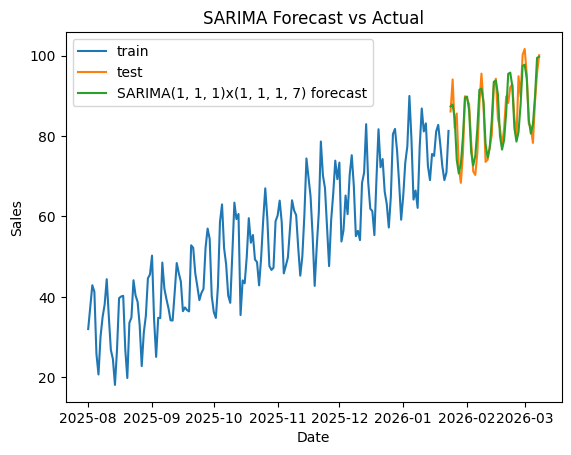

In [7]:
plt.figure()
plt.plot(df["date"].iloc[:split], train, label="train")
plt.plot(df["date"].iloc[split:], test, label="test")
plt.plot(df["date"].iloc[split:], forecast, label=f"SARIMA{order}x{seasonal_order} forecast")
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [8]:
results = pd.DataFrame({
    "date": df["date"].iloc[split:].values,
    "y_true": test.values,
    "y_pred": np.array(forecast)
})
results.head()


,date,y_true,y_pred
0,2026-01-24,86.089500,87.354225
1,2026-01-25,94.056566,87.819569
2,2026-01-26,82.047333,84.386703
3,2026-01-27,85.582935,74.042778
4,2026-01-28,72.068459,70.665388
